In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from scipy import stats

pd.set_option('display.max_columns', None) # Отобразить все колонки

# Знакомство с данными

Для анализа будем использовать следующий набор данных: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). Каждая строка набора данных представляет клиента, а каждый столбец содержит атрибуты клиента. Набор данных включает информацию:

1) Клиенты, которые ушли в течение последнего месяца — колонка называется `Churn`.
2) Услуги, на которые подписался каждый клиент — телефон, несколько линий, интернет, онлайн-безопасность, резервное копирование, защита устройств, техническая поддержка, потоковое ТВ и фильмы.
3) Информация о счетах клиентов — как долго они являются клиентами, контракт, способ оплаты, безналичные счета, ежемесячные платежи и общая сумма платежей.
4) Демографическая информация о клиентах — пол, возраст, наличие партнеров и иждивенцев.

![Telco Customer Churn](./dataset-cover.jpg)

In [2]:
df = pd.read_csv("./Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Описательный анализ данных

Рассмотрим данные — изучим медианы, средние, дисперсии и т.д.

In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Выводы**:

1) 16% клиентов являются пожилыми.
2) Медианное количество месяцев, в течение которых клиент оставался в компании, равно 29 (почти 2.5 года).
3) Медианная сумма, взимаемая с клиента ежемесячно, равна 70.
4) Максимальное количество месяцев, в течение которых клиент оставался в компании, равно 72 (6 лет).
5) Максимальная сумма, взимаемая с клиента ежемесячно, равна 119.
6) Минимальная сумма, взимаемая с клиента ежемесячно, равна 18.
7) Средние и медианные значения числовых данных примерно одинаковые, а это значит, что выбросы отсутствуют в выборке.

Рассмотрим уникальные значения категориальных признаков.

In [4]:
df.describe(include=object)

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


**Выводы:**

1) Большинство клиентов являются мужчинами.
2) В основном клиенты не пользуются дополнительными услугами (онлайн-безопасностью, резервным копированием, защитой устройств и т.д.).
3) Подавляющее большинство клиентов подключили кабельный интернет.
4) У многих клиентов есть телефонная связь без дополнительных линий.
5) Большая часть клиентов подписала контракт на один месяц.
6) В большинстве своем клиенты используют безналичный расчет.
7) В основном клиенты не уходили в течение последнего месяца.

# Обработка данных

## Проверка на наличие дубликатов

Проверим датасет на наличие дубликатов и удалим, если они есть.

In [5]:
df.duplicated().sum()

0

Дубликаты отсутствуют, поэтому удалять нечего.

## Проверка на наличие отсутствующих значений

Посмотрим, если ли в датафрейме отсутствующие значения.

In [6]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Отсутствующие значения не обнаружены, однако обратим внимание на столбец `TotalCharges`, в котором есть значения с пустыми строками. Дело в том, что не всегда в данных есть явные пропуски, которые легко индексируются средствами `Pandas`. К сожалению, бывают проблемы с выгрузками данных, некачественными источниками, или когда данные записываются вручную — часто присутствует человеческий фактор. По мере работы с новыми данными лучше проверять на наличие таких данных, иначе из-за этого исследование может исказиться.

In [7]:
df.describe(include=object)['TotalCharges']

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

Реализуем функцию для проверки всех столбцов на наличие неявных пропусков.

In [8]:
for col in df:
    if df[col].dtype == 'object':
        nans = df[col].apply(lambda x: len(x.strip()) == 0).sum()
        if nans > 0:
            print(f'Неявные пропуски столбца {col}:', nans)

Неявные пропуски столбца TotalCharges: 11


Видим, что таких пропусков 11 в столбце `TotalCharges`. Преобразуем этот столбец в числовой с аргументом `errors='coerce'`, который позволяет некорректные значения преобразовать в `NaN`.

In [9]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

df[df["TotalCharges"].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Теперь можно либо удалить эти строки, либо заменить их на какие-то значения. Лучше заменить, чтобы не потерять данные, однако в таком случае необходимо найти зависимость. Посмотрим внимательно на столбцы `tenure`, `MonthlyCharges` и `TotalCharges`.

In [10]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].sample(5)

,tenure,MonthlyCharges,TotalCharges
139,1,70.45,70.45
6201,5,80.70,374.80
5154,17,104.20,1743.50
1351,11,20.45,250.80
260,3,41.15,132.20


Общая сумма, списанная с клиента, равна сумме, взимаемой с клиента ежемесячно умноженной на количество времени (`TotalCharges` = `MonthlyCharges` * время).

In [11]:
df[(df['TotalCharges'] / df['MonthlyCharges']) == df['tenure']].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
27,8665-UTDHZ,Male,0,Yes,Yes,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,30.20,Yes
33,7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No


Нашей гипотезе есть место быть. Однако в данном датасете указано только количество месяцев, без точного времени, поэтому будет грубо просто перемножить один столбец на другой. Но пропуски мы уже можем заменить на 0, так как в тех строках `tenure` равно 0, где есть пропуски в столбце `TotalCharges`.

In [12]:
df.fillna({'TotalCharges': 0}, inplace=True)

Пропусков больше нет.

## Изменение типа данных

Рассмотрим все данные, заменим типы на нужные (при необходимости).

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Типы заменять нигде не нужно. К числовым типам относятся только столбцы `SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`. Остальные данные, как и положено, являются категориальными.

## Обработка признаков

Необходимо предобработать данные, то есть перевести все текстовые признаки в числовые. Нужно таким образом всегда преобразовывать данные, потому что методы машинного обучения и большинство алгоритмов оперируют именно числовыми признаками. Сделаем копию оригинального датафрейма, чтобы не портить данные.

In [15]:
df_copy = df.copy()

df_copy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Для обработки текстовых признаков будем использовать средства библиотеки `Pandas` `Series.cat.codes`. С помощью этой записи можем преобразовать каждое уникальное значение текстовой переменной в уникальный числовой код. Соберем список из тех столбцов, которые нам необходимо обработать.

In [16]:
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
        'Churn']

df_copy[cols] = df_copy[cols].astype('category').apply(lambda x: x.cat.codes)

df_copy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Теперь все столбцы имеют числовые признаки, кроме столбца `customerID`. Этот столбец можем просто удалить, потому что он выполняет роль идентификатора клиента. С этим прекрасно справляются обычные индексы.

In [17]:
df_copy.drop('customerID', axis=1, inplace=True)

df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [18]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int8   
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int8   
 3   Dependents        7043 non-null   int8   
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int8   
 6   MultipleLines     7043 non-null   int8   
 7   InternetService   7043 non-null   int8   
 8   OnlineSecurity    7043 non-null   int8   
 9   OnlineBackup      7043 non-null   int8   
 10  DeviceProtection  7043 non-null   int8   
 11  TechSupport       7043 non-null   int8   
 12  StreamingTV       7043 non-null   int8   
 13  StreamingMovies   7043 non-null   int8   
 14  Contract          7043 non-null   int8   
 15  PaperlessBilling  7043 non-null   int8   
 16  PaymentMethod     7043 non-null   int8   


Теперь все отлично.

# Анализ данных, проверка гипотез

**Гипотеза** — это предположения. Важно понять, соответствуют ли выборочные данные вероятностным предположениям о группе в целом. Если предположения верны, то данные не должны им противоречить или показывать очень маловероятные результаты. После того как гипотезы были сформулированы, можно приступить к проверке этих гипотез. Существуют двусторонняя и односторонняя гипотезы:

**Двусторонняя гипотеза**:

**H0** — нулевая гипотеза. Может звучать следующим образом: «Среднее время выполнения задачи на компьютере A не отличается от среднего времени выполнения на компьютере B».
**H1** — альтернативная гипотеза. Звучит как: «Среднее время выполнения задачи на компьютере A отличается от среднего времени выполнения на компьютере B».

Такая гипотеза называется двусторонней, так как время выполнение задачи на компьютере А может быть как меньше, так и больше, чем на компьютере В.

**Односторонняя гипотеза**:

**H0** — нулевая гипотеза. Может звучать следующим образом: «Среднее время выполнения задачи на компьютере A равно среднему времени выполнения на компьютере B».
**H1** — альтернативная гипотеза. Звучит как: «Среднее время выполнения задачи на компьютере A меньше среднего времени выполнения на компьютере B».

Такая гипотеза называется односторонней, так как время выполнение задачи на компьютере может сместиться лишь в одну сторону.

Гипотезы проверяются с помощью расчёта **p-value** («значение вероятности») — это вероятность получить наблюдаемые данные (или более экстремальные результаты), если нулевая гипотеза верна. Чем меньше **p-value**, тем больше оснований отклонить нулевую гипотезу и принять альтернативную (различия между группами статистически значимы). Обычно, если **p-value** меньше 0,05 (или 5%), то различия считаются статистически значимыми.

## Статистический анализ на равенство средних двух совокупностей

Метод `scipy.stats.ttest_ind()` используется для определения статистической значимости различий между средними значениями двух независимых выборок. Она выполняет двухсторонний тест t-критерия Стьюдента и возвращает t-статистику и двустороннее p-значение.

Аргументы функции:
 - первая выборки значений;
 - вторая выборка значений;
 - `equal_var` — опциональный параметр для указания равенства дисперсий между двумя выборками. По умолчанию, `equal_var=True`.

Перед тем, как проводить тест, нужно придерживаться трех правил:

1. **Независимость выборок** — данные в двух группах должны быть независимыми друг от друга. Если рассматриваются две выборки после определенного времени — лучше использовать другой тест.
2. **Дисперсии данных в каждой группе должны быть примерно равными.** В принципе, если значений больше 30 и выборки по размеру равны — можно пробовать.
3. **Распределение данных в каждой группе должно быть нормальным.** Но это условие тоже не препятствие — как говорилось в прошлом правиле, если значений много — они будут распределены вокруг истинного среднего (среднего генеральной совокупности). Для корректного использования t-теста это необязательно.

В параметре `equal_var` указываем `False` только в том случае, если размеры выборок не равны и есть сомнения, что дисперсии равные.

Сравним две выборки — `Churn='No'` и `Churn='Yes'`. Гипотеза — среднее количество месяцев, в течение которых клиент оставался в компании, отличается между двумя выборками. Предположим, что две выборки являются независимыми. Проверим на равенство средних двух совокупностей.

In [19]:
churn_no = df_copy.loc[df_copy.Churn == 0, 'tenure'].reset_index(drop=True) # Series, в котором выбираются только строки с Churn=0 с одним столбцом tenure
churn_yes = df_copy.loc[df_copy.Churn == 1, 'tenure'].reset_index(drop=True) # Series, в котором выбираются только строки с Churn=1 с одним столбцом tenure

alpha = .05 # Критерий значимости

_, p_value = stats.ttest_ind(churn_no, churn_yes)

if p_value < alpha:
    print(f'P-value: {p_value:.5f}. H0 отвергается.')
else:
    print(f'P-value: {p_value:.5f}. H0 не отвергается.')

P-value: 0.00000. H0 отвергается.


Среднее количество месяцев, в течение которых клиент оставался в компании, отличается между двумя выборками. То есть гипотеза подтвердилась.

## Статистический анализ на норму

Анализы на норму используются для определения того, нормально ли распределен набор данных, и для проверки того, насколько вероятно, что случайная величина в наборе данных будет нормально распределена.

Популярные методы — K'2-тест Д'Агостино, критерий Шапиро-Уилка, критерий Андерсона-Дарлинга.

Разница между этими тремя тестами заключается в способе вычисления статистики и критических значений, а также в основе предположений и гипотез о данных. Все три теста предназначены для проверки нормальности данных, но могут давать разные результаты в зависимости от особенностей выборки.

Гипотезы:

**H0** — выборка имеет распределение по Гауссу (нормальное распределение).
**H1** — выборка не имеет распределения по Гауссу (не нормальное распределение).

Примечание: тест Шапиро-Уилка **не выполняется** в том случае, если размер выборки > 5000 и для этого теста p-значение может быть неточным для N > 5000.

Выберем числовые признаки и проведем анализ — соответствуют ли распределения нормальному. Будем проводить статистический анализ на норму с помощью теста К'2-тест Д'Агостино. Тест Шапиро-Уилка использовать не будем, поскольку у нас в выборке более 5000 значений.

In [20]:
# Создадим кортеж data, в котором будут храниться все наши столбцы с числовыми признаками
data = (df_copy['SeniorCitizen'], df_copy['tenure'], df_copy['MonthlyCharges'], df_copy['TotalCharges'])

for col in data:
    _, p_value = stats.normaltest(col)
    
    print(f'Столбец: {col.name}')
    
    if p_value < alpha:
        print(f'P-value: {p_value:.5f}. Выборка НЕ имеет распределения по Гауссу (Н0 отвергается).')
    else:
        print(f'P-value: {p_value:.5f}. Выборка имеет распределение по Гауссу (Н0 не отвергается).')
        
    print()

Столбец: SeniorCitizen
P-value: 0.00000. Выборка НЕ имеет распределения по Гауссу (Н0 отвергается).

Столбец: tenure
P-value: 0.00000. Выборка НЕ имеет распределения по Гауссу (Н0 отвергается).

Столбец: MonthlyCharges
P-value: 0.00000. Выборка НЕ имеет распределения по Гауссу (Н0 отвергается).

Столбец: TotalCharges
P-value: 0.00000. Выборка НЕ имеет распределения по Гауссу (Н0 отвергается).


Распределения не соответствуют нормальным.

## Двумерный анализ

Обширный статистический анализ с проверкой различных гипотез на основе парных типов данных: 

* числовые и числовые данные;
* числовые и порядковые данные;
* порядковые и порядковые данные;
* категориальные и категориальные данные.

Основные гипотезы:

**H0** — эти два признака независимы.
**H1** — существует зависимость между признаками.

Необходимо выяснить причину ухода клиентов. Для этого проведем полный анализ с помощью статистических гипотез взаимосвязи всех признаков с таргетом `Churn` (целевым признаком). Сформулируем несколько гипотез:

1. Пол клиента оказывает влияние на его склонность к уходу.
2. Ежемесячная сумма, которую клиент платит, также влияет на его вероятность ухода.
3. Способ оплаты, выбранный клиентом, связан с его склонностью к уходу.
4. Наличие или отсутствие безналичных счетов у клиента связано с вероятностью его ухода из компании.
5. Срок действия контракта заказчика связан с его вероятностью ухода.

Для проведения проверки гипотез применим три метода двумерного анализа: коэффициент Пирсона, коэффициент Спирмена и коэффициент V Крамера. Далее проанализируем результаты.

Объявим функцию, которая будет искать взаимосвязи в столбцах методами Спирмена и Пирсона.

In [21]:
def determine_correlation(targets, features, method): # Функция для определения взаимосвязей между двумя столбцами
    alpha = .05 # Критерий значимости
    
    correlation, p_value = method(targets, features)

    print(f'Коэффициент корреляции: {correlation}', f'P_value: {p_value}', sep = '\n')

    if p_value > alpha:
        print('Вероятно, у них нет монотонной взаимосвязи (не удается отклонить H0)')
    else:
        print('Вероятно, имеют монотонную взаимосвязь (отклоняем H0)')

### Коэффициент Пирсона

Для столбцов `Churn` и `gender`.

In [22]:
determine_correlation(df_copy['Churn'], df_copy['gender'], stats.pearsonr)

Коэффициент корреляции: -0.00861209507899786
P_value: 0.46990453909803853
Вероятно, у них нет монотонной взаимосвязи (не удается отклонить H0)


Для столбцов `Churn` и `MonthlyCharges`.

In [23]:
determine_correlation(df_copy['Churn'], df_copy['MonthlyCharges'], stats.pearsonr)

Коэффициент корреляции: 0.19335642223784577
P_value: 2.7066456068941355e-60
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `PaymentMethod`.

In [24]:
determine_correlation(df_copy['Churn'], df_copy['PaymentMethod'], stats.pearsonr)

Коэффициент корреляции: 0.1070620058734034
P_value: 2.0751009725552834e-19
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `PaperlessBilling`.

In [25]:
determine_correlation(df_copy['Churn'], df_copy['PaperlessBilling'], stats.pearsonr)

Коэффициент корреляции: 0.19182533166646795
P_value: 2.3565543205824073e-59
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `Contract`.

In [26]:
determine_correlation(df_copy['Churn'], df_copy['Contract'], stats.pearsonr)

Коэффициент корреляции: -0.39671262920984096
P_value: 3.66667506289468e-264
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


### Коэффициент Спирмена

Для столбцов `Churn` и `gender`.

In [27]:
determine_correlation(df_copy['Churn'], df_copy['gender'], stats.spearmanr)

Коэффициент корреляции: -0.00861209507899781
P_value: 0.4699045390980453
Вероятно, у них нет монотонной взаимосвязи (не удается отклонить H0)


Для столбцов `Churn` и `MonthlyCharges`.

In [28]:
determine_correlation(df_copy['Churn'], df_copy['MonthlyCharges'], stats.spearmanr)

Коэффициент корреляции: 0.18474274666624488
P_value: 4.132385749669143e-55
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `PaymentMethod`.

In [29]:
determine_correlation(df_copy['Churn'], df_copy['PaymentMethod'], stats.spearmanr)

Коэффициент корреляции: 0.10226975470600297
P_value: 7.712949067558699e-18
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `PaperlessBilling`.

In [30]:
determine_correlation(df_copy['Churn'], df_copy['PaperlessBilling'], stats.spearmanr)

Коэффициент корреляции: 0.19182533166646787
P_value: 2.356554320581795e-59
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Для столбцов `Churn` и `Contract`.

In [31]:
determine_correlation(df_copy['Churn'], df_copy['Contract'], stats.spearmanr)

Коэффициент корреляции: -0.4062615766488807
P_value: 3.779860316096388e-278
Вероятно, имеют монотонную взаимосвязь (отклоняем H0)


Исходя из этого можно сделать вывод, что коэффициенты Спирмена и Пирсона в целом дают схожие результаты и все упомянутые признаки в некоторой степени коррелируют с целевым признаком (`Churn`), за исключением пола (`gender`). Пол не имеет никакой связи с целевым признаком. То есть, все гипотезы подтвердились, кроме первой.

### Коэффициент V Крамера

Объявим функцию, которая будет искать взаимосвязи в столбцах методом V Крамера.

In [32]:
# Метод V Крамера
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [33]:
features = ['gender', 'MonthlyCharges', 'PaymentMethod', 'PaperlessBilling', 'Contract']

for feature in features:
    print(f'Коэффициент корреляции для столбцов Churn и {feature} равен\n{cramers_v(df["Churn"], df[feature]).round(3)}')

Коэффициент корреляции для столбцов Churn и gender равен
0.0
Коэффициент корреляции для столбцов Churn и MonthlyCharges равен
0.277
Коэффициент корреляции для столбцов Churn и PaymentMethod равен
0.303
Коэффициент корреляции для столбцов Churn и PaperlessBilling равен
0.191
Коэффициент корреляции для столбцов Churn и Contract равен
0.41


Из этого можно сделать вывод, что вероятность ухода клиента не зависит от его пола, однако все остальные признаки в разной степени коррелируют между собой.

### Phik-корреляция

**Phik** (φk) корреляция — это относительно новый метод оценки зависимости между двумя переменными, независимо от их типа (категориальные или числовые). В отличие от традиционных методов корреляции, таких как коэффициенты Пирсона или Спирмена, Phik корреляция может справляться с любыми типами данных и обеспечивает более надежные результаты для нелинейных и сложных зависимостей.

interval columns not set, guessing: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


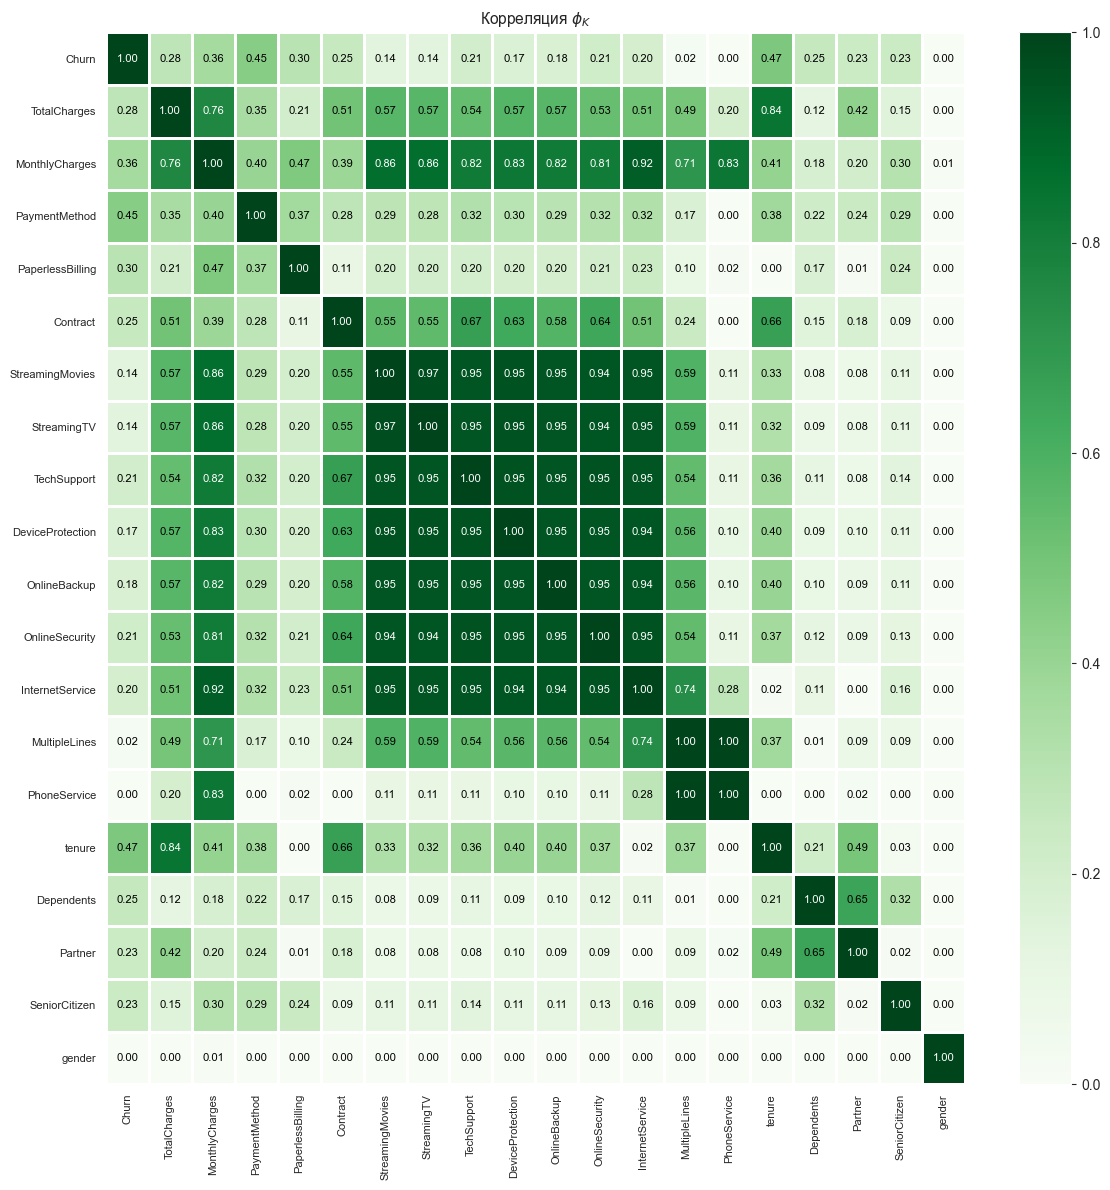

In [34]:
phik_overview = df_copy.phik_matrix()

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Greens',
                        title=r'Корреляция $\phi_K$',
                        fontsize_factor=0.8, figsize=(12, 12))

plt.tight_layout()

Исходя из этого, можно сделать промежуточный вывод, что гипотезы в целом подтверждаются. Пол не имеет никакой связи с признаком `Churn`. Однако, столбцы `tenure`, `PaymentMethod`, `MonthlyCharges`, `PaperlessBilling` и `Contract` имеют наибольшую связь с признаком `Churn`. Выберем три признака, которые имеют связь с целевой переменной, и проанализируем их взаимосвязь. После этого сможем интерпретировать результаты исследования.

Сгрупируем данные, чтобы проверить, как именно связаны между собой два признака `Churn` и `tenure`.

* 0 -> не покинули компанию;
* 1 -> покинули компанию.

In [35]:
df_copy.groupby(by='Churn', as_index=False).agg(median_tenure = ('tenure', 'median'))

,Churn,median_tenure
0,0,38.0
1,1,10.0


Отсюда можно сделать вывод: клиенты, которые склонны покинуть компанию, пробыли в ней меньше времени, в то время как клиенты, которые остаются, провели в ней больше времени.

Сгрупируем данные, чтобы проверить, как связаны между собой два признака `Churn` и `MonthlyCharges`.

In [36]:
df_copy.groupby('Churn', as_index=False).agg(median_monthly_charges = ('MonthlyCharges', 'median'))

,Churn,median_monthly_charges
0,0,64.425
1,1,79.650


Можно сделать вывод, что клиенты, которые имеют склонность покинуть компанию, обычно платят за услуги больше, в сравнении с клиентами, которые предпочитают оставаться.

Сгрупируем данные, чтобы проверить, как связаны между собой признаки `Churn` и `PaperlessBilling`.



In [37]:
df_copy.groupby('Churn', as_index=False).agg(num_of_paperless_billings = ('PaperlessBilling', 'sum'))

,Churn,num_of_paperless_billings
0,0,2771
1,1,1400


Как можно заметить, среди клиентов, которые проявляют склонность к оттоку, намного меньше таких, у которых имеются безналичные счета.

# Вывод

В результате исследования было обнаружено, что пол `gender` не имеет связи с таргетом `Churn`. Однако, следующие признаки — `tenure`, `PaymentMethod`, `MonthlyCharges`, `PaperlessBilling` и `Contract` — в большей мере коррелируют с целевым признаком. Можно также сделать следующие выводы:

1. Коэффициент корреляции 0.47 между столбцами `Churn` и `tenure` указывает на наличие положительной связи между ними. Это означает, что длительность пребывания клиента в компании (`tenure`) является фактором, который может влиять на решение клиента остаться в компании или уйти. Отсюда возникает логичный вывод, что чем дольше клиент остается в компании, тем меньше вероятность того, что он уйдет. Поэтому важно привлекать новых клиентов и удерживать их, чтобы они оставались в компании как можно дольше. Если компания уделяет внимание удержанию своих клиентов, то это может помочь уменьшить отток клиентов и увеличить прибыль компании.

2. Коэффициент корреляции 0.36 между столбцами `Churn` и `MonthlyCharges` указывает на наличие положительной связи между ними. Это говорит о том, что сумма, которую клиенты платят ежемесячно, может оказывать влияние на решение об уходе из компании. Возможно, клиенты, которые платят большую сумму, имеют определенные ожидания от услуг и качества обслуживания. Для удержания клиентов, компания может обратить внимание на ценообразование или улучшить качество предоставляемых услуг.

3. Коэффициент корреляции 0.3 между столбцами `Churn` и `PaperlessBilling` указывает на положительную связь. Это говорит о том, что наличие или отсутствие безналичных счетов может оказывать влияние на решение клиентов об уходе из компании. Вероятно, клиенты, которые предпочитают использовать безналичные счета, ценят дополнительные преимущества и удобство, которые компания может предоставить. В связи с этим, клиенты, которые предпочитают оплачивать наличными деньгами, могут быть более склонными к оттоку, поскольку им не доступны эти дополнительные преимущества. Можно применить два подхода: предоставить больше преимуществ клиентам с наличным платежом для снижения их оттока, учитывая при этом возможные ограничения. Также можно сосредоточиться на предоставлении дополнительных преимуществ клиентам, использующим безналичные счета, включая выгодные условия или специальные акции, чтобы стимулировать переход на безналичный расчет клиентов, которые пользуются наличкой. Такой подход позволит расширить базу клиентов и способствовать росту использования безналичных счетов.

Упомянутые факторы не охватывают все возможные причины ухода клиента из компании. Однако, принимая во внимание представленные выше аспекты, возможно достичь значительного снижения оттока клиентов и увеличить прибыль.